In [20]:
import tensorflow as tf
import os
import sys
from tensorflow import keras
import sklearn
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, ConfusionMatrixDisplay
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import Canny
from skimage.morphology import dilation, erosion, white_tophat, skeletonize
from skimage.morphology import disk 
from skimage import transform
from sklearn.svm import SVC

In [2]:
class_names = ['MALIGNANTMASSES', 'CALC', 'BENIGNMASSES', 'NORM']
class_names_label = {class_names:i for i, class_names in enumerate(class_names)}
print(class_names_label)

IMAGE_SIZE = (224, 224, 3)

def load_data():
    main_directory = r"C:\Users\hp\Documents\CursoML\processed\todas"
    
    output = []
    images = []
    labels = []
         
    for folder in os.listdir(main_directory):
        print(folder)
        label = list(class_names_label.values())[int(folder)-1]

        for file in os.listdir(os.path.join(main_directory, folder)):
            img_path = os.path.join(os.path.join(main_directory, folder), file)

            image = io.imread(img_path, as_gray=True, plugin='matplotlib')
            image = transform.resize(image, IMAGE_SIZE)

            images.append(image)
            labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    output.append(images)
    output.append(labels)
        
    return output

{'MALIGNANTMASSES': 0, 'CALC': 1, 'BENIGNMASSES': 2, 'NORM': 3}


In [3]:
total_images, total_labels = load_data() 

1
2
3
4


In [4]:
len(total_images)

1139

In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(total_images, total_labels, test_size=0.2)
print('Datos de aprendizaje: ', train_X.shape, train_Y.shape)
print('Datos de prueba: ', test_X.shape, test_Y.shape)

Datos de aprendizaje:  (911, 224, 224, 3) (911,)
Datos de prueba:  (228, 224, 224, 3) (228,)


In [6]:
import keras
#from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.layers.advanced_activations import LeakyReLU

#CREAR EL MODELO

cancer_model = tf.keras.models.Sequential() #pila de capas

cancer_model.add(tf.keras.layers.Conv2D(128, kernel_size=(5,5), activation='linear', padding='same', input_shape=(224,224,3))) #capa de convolucion
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D((2, 2),padding='same')) #agrupacion
cancer_model.add(tf.keras.layers.Conv2D(128, kernel_size=(5,5), activation = 'relu'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
cancer_model.add(tf.keras.layers.Conv2D(128, (5, 5), activation='linear', padding='same'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
cancer_model.add(tf.keras.layers.Flatten())
cancer_model.add(tf.keras.layers.Dense(128, activation='linear'))
cancer_model.add(LeakyReLU(alpha=0.1))
cancer_model.add(tf.keras.layers.Dense(4, activation='softmax')) #capa softmax para clasificacion

cancer_model.summary()

cancer_model.compile(optimizer="adam",
                     loss=keras.losses.sparse_categorical_crossentropy,
                     metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 108, 108, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                    

In [7]:
epochs = 5
batch_size = 64 #numero de muestras por actualizacion 
cancer_train = cancer_model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs)

Epoch 1/5
15/15 [==============================] - 257s 17s/step - loss: 2.4351 - accuracy: 0.4446
Epoch 2/5
15/15 [==============================] - 268s 18s/step - loss: 0.9078 - accuracy: 0.7025
Epoch 3/5
15/15 [==============================] - 268s 18s/step - loss: 0.7254 - accuracy: 0.7607
Epoch 4/5
15/15 [==============================] - 262s 17s/step - loss: 0.6382 - accuracy: 0.8013
Epoch 5/5
15/15 [==============================] - 260s 17s/step - loss: 0.5632 - accuracy: 0.8101


In [8]:
test_eval = cancer_model.evaluate(test_X, test_Y)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

8/8 [==============================] - 32s 2s/step - loss: 0.6503 - accuracy: 0.7851
Test loss: 0.6502804756164551
Test accuracy: 0.7850877046585083


In [9]:
predictions = cancer_model.predict(test_X)
pred_labels = np.argmax(predictions, axis = 1)
print(classification_report(test_Y, pred_labels))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        74
           1       0.64      0.87      0.74        55
           2       0.90      0.76      0.82        46
           3       0.70      0.53      0.60        53

    accuracy                           0.79       228
   macro avg       0.79      0.77      0.77       228
weighted avg       0.80      0.79      0.78       228



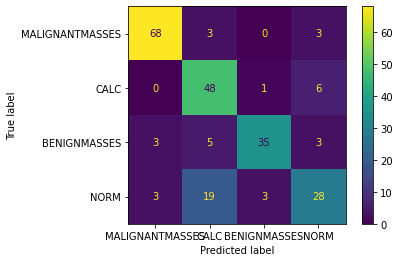

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_Y, pred_labels),
                              display_labels=class_names)
disp.plot()
plt.show()


In [24]:
precision_score(test_Y, pred_labels, average='weighted')

0.7964125056230319

In [28]:
accuracy_score(test_Y, pred_labels,normalize=False)

179

In [26]:
recall_score(test_Y, pred_labels, average='weighted')

0.7850877192982456

In [29]:
#vgg16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

model = VGG16(weights = 'imagenet', include_top = False)
model = Model(inputs=model.inputs, outputs= model.layers[-5].output)

In [31]:
train_features = model.predict(train_X)
test_features = model.predict(test_X)

In [32]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten

model2 = VGG16(weights = 'imagenet', include_top = False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape = (14, 14, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = Dense(4, activation = 'softmax')(x)

#new model
new_model = Model(layer_input, x)

In [33]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = new_model.fit(train_features, train_Y, batch_size = 128, epochs = 10)

Epoch 1/10
8/8 [==============================] - 51s 6s/step - loss: 1.2516 - accuracy: 0.4709
Epoch 2/10
8/8 [==============================] - 50s 6s/step - loss: 0.9122 - accuracy: 0.6674
Epoch 3/10
8/8 [==============================] - 50s 6s/step - loss: 0.5958 - accuracy: 0.8101
Epoch 4/10
8/8 [==============================] - 51s 6s/step - loss: 0.5108 - accuracy: 0.8145
Epoch 5/10
8/8 [==============================] - 53s 6s/step - loss: 0.5016 - accuracy: 0.8321
Epoch 6/10
8/8 [==============================] - 50s 6s/step - loss: 0.4837 - accuracy: 0.8222
Epoch 7/10
8/8 [==============================] - 50s 6s/step - loss: 0.4640 - accuracy: 0.8310
Epoch 8/10
8/8 [==============================] - 50s 6s/step - loss: 0.4297 - accuracy: 0.8375
Epoch 9/10
8/8 [==============================] - 50s 6s/step - loss: 0.4432 - accuracy: 0.8299
Epoch 10/10
8/8 [==============================] - 51s 6s/step - loss: 0.4239 - accuracy: 0.8397


In [37]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)
pred_labels =np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_Y, pred_labels)))


Accuracy : 0.7675438596491229


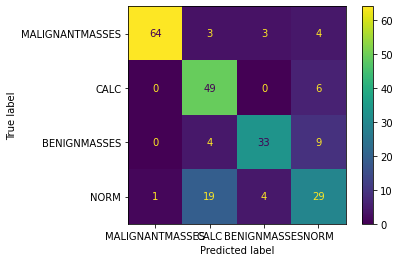

In [38]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_Y, pred_labels),
                              display_labels=class_names)
disp.plot()
plt.show()